<a href="https://colab.research.google.com/github/CelaPablo/SOA-EA2/blob/master/HPC/Cela_Pablo_ejercicio_2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

En el siguiente ejercicio, se mezclan dos imagenes parametrizadas.

Una de las imagenes se va a representar como el background de la resultante, mientras que la otra imagen se va a montar al frente (solo aquellos pixeles que sean de color negro).

Para ello, se toman todos los pixeles y se los compara con el RGB negro [0, 0, 0]. Si el pixel tomado es de color negro se deja al frente de la imagen resultante; para todos los pixels que no sean de color negro se toman los pixeles de la imagen de background.

Con este ejercicio, se pretende entender el funcionamiento basico del Lenguaje Python [1], Google Colab [2,3] y tratamiento de imagenes a bajo nivel.

En este ejercicio en particular, tambien se pretende entender el funcionamiento en paralelo con mas de una dimensión y poder comparar los resultados con la versión en serie.

---
# Armado del ambiente
Se toman la dirección web de dos imagenes.

1 - En blanco y negro.

2 - Una imagen en color que se representara como background de la imagen resultante.

Ambas imagenes se las deja disponible en el contexto del cuaderno Colab.

***Aclaración importante: ambas imagenes deben tener el mismo tamaño***

In [ ]:
#@title ## Parámetros de ejecución

#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://i.pinimg.com/originals/be/4a/98/be4a98faeda134f012cc442bd67536a7.jpg" #@param {type:"string"}

#@markdown ---
#@markdown ### Especifique la URL del background:
background_img = "https://i.ibb.co/8mnyq9g/colores.jpg" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg
!wget {background_img} -O background_img.jpg


---
## Instala el modulo CUDA de Python en el cuaderno.

In [ ]:
!pip install pycuda

# Desarrollo - Ejecución CPU-GPU.

Combinación de dos imagenes.

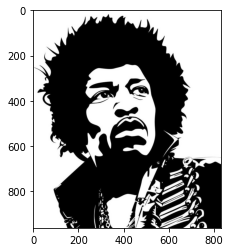

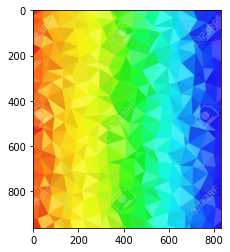

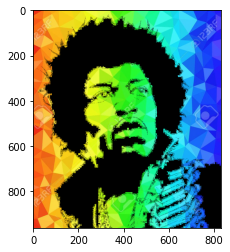

Tiempo en procesar las imagenes: 0.149 [ms]
Tiempo de representacion de las imagenes: 592.47 [ms]
Tiempo Total: 625.99 [ms]


In [6]:
try:
  %matplotlib inline
  from datetime import datetime
  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
  from matplotlib import pyplot as plt
except:
  print("Primero deben instalarse las dependencias - Armado del ambiente e instalaciónn de CUDA.")

tiempo_total = datetime.now()

# ------------------------------------------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos --------------
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# ------------------------------------------------------------------------------

# Cargo la imagen y el background. ---------------------------------------------
try:
    imagepath = 'imagen.jpg'
    image = Image.open(imagepath)

    imagepath = 'background_img.jpg'
    background = Image.open(imagepath)
except IOError:
    print("No se pudo abrir la imagen de la url: ", imagepath)
  
try:
  # Proporciones de la imagen y del background. ---------------------------------- 
  img_alto, img_ancho = image.size 
  back_alto, back_ancho = background.size 

  if (img_alto != back_alto) or (img_ancho != back_ancho):
    raise ValueError("El background debe ser de un tamaño igual al de la imagen.");

  # Convierto la imagen comprimida en JPEG/PNG a array. ------------------------
  img_cpu = numpy.asarray(image)
  back_cpu = numpy.asarray(background)
  result_cpu = numpy.empty_like(img_cpu)

  # Reservo memoria en GPU. ----------------------------------------------------
  img_gpu = cuda.mem_alloc(img_cpu.nbytes)
  back_gpu = cuda.mem_alloc(back_cpu.nbytes)

  # GPU - Copio la memoria al GPU. ---------------------------------------------
  cuda.memcpy_htod(img_gpu, img_cpu)
  cuda.memcpy_htod(back_gpu, back_cpu)

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img(int ancho, int alto, char *img, char *back) {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      int index = (idx+(idy*ancho))*3;
      float RI = (float) img[index];
      float GI = (float) img[index+1];
      float BI = (float) img[index+2];

      if(RI + GI + BI != 0.0) {
        // Escribo el color del pixel.
        img[index]   = back[index];
        img[index+1] = back[index+1];
        img[index+2] = back[index+2];
      }
    }
  }
  """) 

  # CPU - Genero la función kernel. --------------------------------------------
  kernel = module.get_function("kernel_img")

  tiempo_img = datetime.now()

  # Se calculan las dimensiones de trabajo. ------------------------------------
  dim_hilo_x = 16
  dim_bloque_x = numpy.int((img_ancho+dim_hilo_x-1) / dim_hilo_x)

  dim_hilo_y = 16
  dim_bloque_y = numpy.int((img_alto+dim_hilo_y-1) / dim_hilo_y)

  kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_gpu, back_gpu, block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

  tiempo_img = datetime.now() - tiempo_img
  tiempo_representacion = datetime.now()

  # GPU - Copio el resultado desde la memoria GPU. -----------------------------
  cuda.memcpy_dtoh(result_cpu, img_gpu)

  # Muestro la imagen original. ------------------------------------------------
  plt.figure()
  plt.imshow(img_cpu)
  plt.show()

  # Muestro el background original. --------------------------------------------
  plt.imshow(back_cpu)
  plt.show()

  # Muestro la imagen resultante. ----------------------------------------------
  plt.imshow(result_cpu)
  plt.show()

  tiempo_representacion = datetime.now() - tiempo_representacion 
  tiempo_total = datetime.now() - tiempo_total

  print( "Tiempo en procesar las imagenes:", tiempo_en_ms(tiempo_img), "[ms]")
  print( "Tiempo de representacion de las imagenes:", tiempo_en_ms(tiempo_representacion), "[ms]")
  print( "Tiempo Total:", tiempo_en_ms(tiempo_total), "[ms]")

except ValueError as valerr:
  print (valerr)
except: 
  print("Houston we have a problem!")



---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param       | Lectura de la dirección URL de la imagen en blanco y negro (jpg) a procesar.
CPU      |  @param       | Lectura de la dirección URL del background a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline     | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen a procesar.
CPU      |  Image.open()          | Abre el archivo del background.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.asarray(background) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para la imagen original en GPU.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para el background en GPU.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para el resultado GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | Convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      | cuda.memcpy_dtoh()     | Copio el resultado desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra el background original.
CPU      |  plt.imshow            | Muestra el resultado.



---
# Conclusión

En este ejercicio se afianzo el funcionamiento del trabajo en paralelo. 

En cuanto a los resultado, el trabajo en paralelo es muchisimo mas rapido y su demora solo se ve afectada por los trabajos en CPU como los de mostrar las imagenes y los tiempos de ejecución.

En promedio, con la ejecución en serie obtuve un resultado de 63.221 [ms] (tamando 10 ejecuciones). Por otra parte, con la ejecución en paralelo, el calculo de las diferentes energias se resolvió en un promedio de 0.094 [ms].

## Pasos mas relevantes

1- Reservar memoria en GPU (cuda.mem_alloc).

2- Copiar datos en memoria GPU (cuda.memcpy_htod).

3- Definir la función que va a ejecutar el Kernel.

4- Calcular las dimensiones.

5- Copiar datos de la memoria GPU (cuda.memcpy_dtoh).


---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)
